In [1]:
import os
import h5py
import cv2 # pip install opencv-python

import scipy.ndimage as sp
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import random
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

from PIL import Image
from scipy.ndimage.filters import gaussian_filter

from keras.models import Sequential, Model, model_from_json
from keras.layers import Subtract, Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K 

%matplotlib inline

Using TensorFlow backend.


In [2]:
os.chdir('/Users/hyunwoogu/Dropbox/2019/2019Autumn/Graduation/ResearchGrant/experiment/stimuli')

In [3]:
for i in range(32):
    if i == 0:
        img_list = cv2.imread(str(i+1) + ".png", 1)
        img_list = cv2.resize(img_list, (1600, 1200), interpolation=cv2.INTER_CUBIC)
        img_list = img_list[np.newaxis,:,:,:]
    else:
        im = cv2.imread(str(i+1) + ".png", 1)
        im = cv2.resize(im, (1600, 1200), interpolation=cv2.INTER_CUBIC)
        im = im[np.newaxis,:,:,:]
        img_list = np.concatenate((img_list,im),axis=0)

In [4]:
os.chdir("/Users/hyunwoogu/Dropbox/2019/2019Autumn/Graduation/ResearchGrant/EyeModelRes")

In [5]:
par = pickle.load(open("par.pkl", 'rb')) # slightly modified parameter class from Masse

In [6]:
import SeqTrial
eyeTrial = SeqTrial.Eye(test_mode=True)

In [7]:
par['noise_rnn'] = eyeTrial.noise_sd/10.

In [8]:
def initialize(dims, connection_prob, shape=0.1, scale=1.0):
    w = np.random.gamma(shape, scale, size=dims)
    w *= (np.random.rand(*dims) < connection_prob)
    return np.float32(w)

In [9]:
EI = np.ones(par['n_hidden'],dtype=np.float32)
EI[80:] *= -1 # inhibitory
RNNmask = 1-np.eye(par['n_hidden'],dtype=np.float32)
RNNmask = RNNmask @ np.diag(EI)

In [10]:
par['w_in0'] = initialize([eyeTrial.n_input, par['n_hidden']], par['connection_prob'], shape=0.2, scale=1.)

# RNN weight
par['w_rnn_mask'] = RNNmask

# Initial weights
par['w_out0']     = initialize([par['n_hidden'], 2], par['connection_prob'])
par['b_out0']     = np.zeros((1, 2), dtype=np.float32)

# Correction of initial values
par['w_rnn0'] *= par['w_rnn_mask']

In [11]:
par['w_in_mask'] = np.ones_like(par['w_in0'])
par['w_out_mask'] = np.ones_like(par['w_out0'])

In [12]:
def initialize_weights(par):
    var_dict = {}
    for k, v in par.items():
        if k[-1] == '0':
            name = k[:-1]
            var_dict[name] = tf.Variable(par[k], name)
    w_rnn = var_dict['w_rnn']
    return var_dict, w_rnn

In [13]:
def rnn_cell(rnn_input, h, var_dict, w_rnn):
    # no STSP
    h_post = h

    # Update the hidden state. Only use excitatory projections from input layer to RNN
    # All input and RNN activity will be non-negative
    h = tf.nn.relu(h * (1-par['alpha_neuron'])
        + par['alpha_neuron'] * (rnn_input @ tf.nn.relu(var_dict['w_in'])
        + h_post @ (w_rnn*par['w_rnn_mask']) + var_dict['b_rnn'])
        + tf.random_normal(h.shape, 0, par['noise_rnn'], dtype=tf.float32))

    return h

In [14]:
def run_model(var_dict, w_rnn, input_data):
    # Main model loop
    h = []
    y = []
    h_ = var_dict['h']

    # Loop through the neural inputs to the RNN, indexed in time
    for i in range(len(input_data)):
        h_ = rnn_cell(input_data[i], h_, var_dict, w_rnn)
        h.append(h_)
        y.append(h_ @ tf.nn.relu(var_dict['w_out']) + var_dict['b_out'])
        
    h = tf.stack(h)
    y = tf.stack(y)

    return h, y

In [15]:
del par['w_out_dm0']
del par['b_out_dm0']
del par['w_out_estim0']
del par['b_out_estim0']

In [16]:
def optimize(mask,y,target, w_rnn,h):

    # Calculate the loss functions and optimize the weights
    perf_loss = tf.reduce_mean(mask*tf.nn.softmax_cross_entropy_with_logits_v2(logits = y, labels = target, axis = 2))
    
    # L2 penalty term on hidden state activity to encourage low spike rate solutions
    n = 2 if par['spike_regularization'] == 'L2' else 1
    spike_loss = tf.reduce_mean(h**n)
    weight_loss = tf.reduce_mean(tf.nn.relu(w_rnn)**n)

    # Total loss
    loss = 10000.*perf_loss + par['spike_cost']*spike_loss + par['weight_cost']*weight_loss
    opt = tf.train.AdamOptimizer(learning_rate = par['learning_rate'])
    grads_and_vars = opt.compute_gradients(loss)

    # Apply any applicable weights masks to the gradient and clip
    capped_gvs = []
    for grad, var in grads_and_vars:
        if 'w_rnn' in var.op.name:
            grad *= par['w_rnn_mask']
        elif 'w_out' in var.op.name:
            grad *= par['w_out_mask']
        elif 'w_in' in var.op.name:
            grad *= par['w_in_mask']
        capped_gvs.append((tf.clip_by_norm(grad, par['clip_max_grad_val']), var))

    train_op = opt.apply_gradients(capped_gvs)

    return(perf_loss, spike_loss, weight_loss, loss, train_op)

In [17]:
def get_accuracy(target, output):
    # Calculate argmax along the last dimension
    target_max = np.argmax(target, axis = 2)
    output_max = np.argmax(output, axis = 2)
    # Calculate 2D "average" of match between target_max & output_max 
    accuracy = np.sum(np.float32(target_max == output_max))/np.sum(np.ones(output_max.shape))
    return accuracy

def append_model_performance(model_performance, accuracy, loss, perf_loss, spike_loss, weight_loss, iteration):
    model_performance['accuracy'].append(accuracy)
    model_performance['loss'].append(loss)
    model_performance['perf_loss'].append(perf_loss)
    model_performance['spike_loss'].append(spike_loss)
    model_performance['weight_loss'].append(weight_loss)
    model_performance['iteration'].append(iteration)
    return model_performance

def print_results(iter_num, perf_loss, spike_loss, weight_loss, h, accuracy):
    print(par['trial_type'] + ' Iter. {:4d}'.format(iter_num) + ' | Accuracy {:0.4f}'.format(accuracy) +
      ' | perf loss {:0.4f}'.format(perf_loss) + ' | Spike loss {:0.4f}'.format(spike_loss) +
      ' | Weight loss {:0.4f}'.format(weight_loss) + ' | Mean activity {:0.4f}'.format(np.mean(h)))

In [61]:
tf.reset_default_graph()  # reset graphs in background

In [62]:
# Masks specific to the task
mask = np.zeros([eyeTrial.numSteps, eyeTrial.batchSize])
# mask[eyeTrial.rg_test,:] = 1.
mask[:,:] = 1.

In [63]:
# Define placeholders
x = tf.placeholder(tf.float32, [eyeTrial.numSteps, eyeTrial.batchSize,eyeTrial.n_input], 'input')
m = tf.placeholder(tf.float32, [eyeTrial.numSteps, eyeTrial.batchSize], 'mask')
t = tf.placeholder(tf.float32, [eyeTrial.numSteps, eyeTrial.batchSize,2], 'target')

input_data  = tf.unstack(x, axis=0)
target_data = t

In [64]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['input', 'mask', 'target', 'unstack']

In [65]:
var_dict, w_rnn = initialize_weights(par)

In [66]:
var_dict

{'h': <tf.Variable 'Variable:0' shape=(1, 100) dtype=float32_ref>,
 'w_in': <tf.Variable 'Variable_1:0' shape=(34, 100) dtype=float32_ref>,
 'w_rnn': <tf.Variable 'Variable_2:0' shape=(100, 100) dtype=float32_ref>,
 'b_rnn': <tf.Variable 'Variable_3:0' shape=(1, 100) dtype=float32_ref>,
 'w_out': <tf.Variable 'Variable_4:0' shape=(100, 2) dtype=float32_ref>,
 'b_out': <tf.Variable 'Variable_5:0' shape=(1, 2) dtype=float32_ref>}

In [67]:
h, y = run_model(var_dict, w_rnn, input_data)
perf_loss, spike_loss, weight_loss, loss, train_op = optimize(m,y,t,w_rnn,h)

In [68]:
model_performance = {'accuracy': [], 'perf_loss': [], 'loss': [],'spike_loss': [], 'weight_loss': [], 'iteration': []}
par['iters_between_outputs'] = 50

In [69]:
var_dict

{'h': <tf.Variable 'Variable:0' shape=(1, 100) dtype=float32_ref>,
 'w_in': <tf.Variable 'Variable_1:0' shape=(34, 100) dtype=float32_ref>,
 'w_rnn': <tf.Variable 'Variable_2:0' shape=(100, 100) dtype=float32_ref>,
 'b_rnn': <tf.Variable 'Variable_3:0' shape=(1, 100) dtype=float32_ref>,
 'w_out': <tf.Variable 'Variable_4:0' shape=(100, 2) dtype=float32_ref>,
 'b_out': <tf.Variable 'Variable_5:0' shape=(1, 2) dtype=float32_ref>}

In [70]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [71]:
par['num_iterations'] = 300

In [31]:
model_performance_path = model_performance

In [60]:
model_performance_pos_NEL = model_performance
model_performance_pos_NNL = model_performance

In [78]:
model_performance_path.keys()

dict_keys(['accuracy', 'perf_loss', 'loss', 'spike_loss', 'weight_loss', 'iteration'])

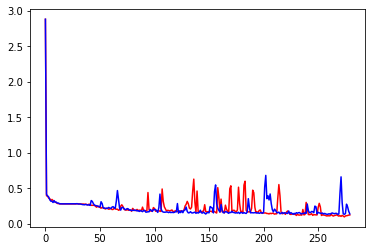

In [97]:
plt.plot(model_performance_path['perf_loss'][:280],'red')
plt.plot(model_performance_pos_NNL['perf_loss'][:280],'blue')
plt.show()

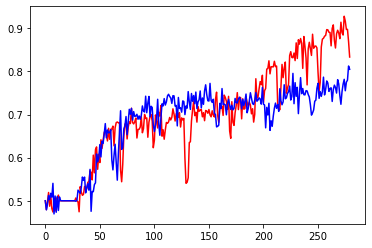

In [96]:
plt.plot(model_performance_path['accuracy'][:280],'red')
plt.plot(model_performance_pos_NNL['accuracy'][:280],'blue')
plt.show()

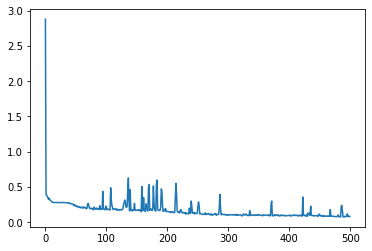

In [84]:
plt.plot(model_performance_path['perf_loss'])

In [ ]:
plt.plot(model_performance_path['perf_loss'])

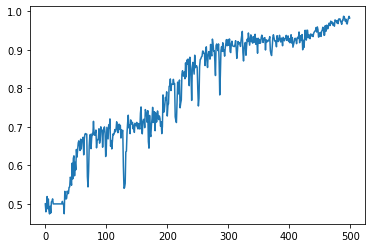

In [77]:
plt.plot(model_performance_path['accuracy'])

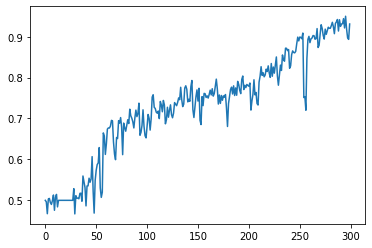

In [75]:
plt.plot(model_performance_pos_NEL['accuracy'])

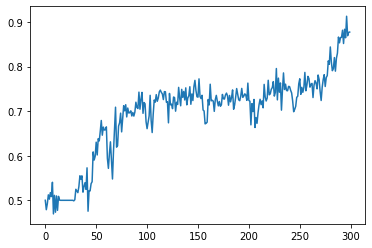

In [76]:
plt.plot(model_performance_pos_NNL['accuracy'])

In [73]:
eyeTrial.condition = [0,2]
with tf.Session(graph=tf.get_default_graph()) as sess: 
    sess.run(tf.global_variables_initializer())
    K.set_session(sess)
    model = model_from_json(loaded_model_json)
    model.load_weights("model.h5")
    OPTIM = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
    
    for i in range(par['num_iterations']):
        trial_info = eyeTrial.generate_trial(model, img_list)
        res_train_op, res_loss, res_perf_loss,res_spike_loss, res_weight_loss, res_y, res_h = \
        sess.run([train_op, loss, perf_loss, spike_loss, weight_loss, y, h],
        feed_dict = {x: trial_info['neural_input'],   # neural_input 
                     t: trial_info['desired_output'], # desired_output
                     m: mask}) # train_mask
        
        accuracy = get_accuracy(trial_info['desired_output'][eyeTrial.rg_test,:,:], res_y[eyeTrial.rg_test,:,:])
        model_performance = append_model_performance(model_performance, accuracy, res_loss, res_perf_loss, res_spike_loss, res_weight_loss, i)
        print_results(i,res_perf_loss, res_spike_loss, res_weight_loss, res_h, accuracy)
        if i%par['iters_between_outputs']==0:
            weights = sess.run(var_dict)
#             print_results(i,res_perf_loss, res_spike_loss, res_weight_loss, res_h, accuracy)        
            


DMS Iter.    0 | Accuracy 0.5000 | perf loss 2.8953 | Spike loss 4.7664 | Weight loss 0.0002 | Mean activity 1.2353
DMS Iter.    1 | Accuracy 0.4953 | perf loss 0.3794 | Spike loss 0.2187 | Weight loss 0.0002 | Mean activity 0.1928
DMS Iter.    2 | Accuracy 0.5167 | perf loss 0.3703 | Spike loss 0.1368 | Weight loss 0.0003 | Mean activity 0.1227
DMS Iter.    3 | Accuracy 0.4870 | perf loss 0.3940 | Spike loss 0.1094 | Weight loss 0.0004 | Mean activity 0.0986
DMS Iter.    4 | Accuracy 0.5111 | perf loss 0.3408 | Spike loss 0.0958 | Weight loss 0.0006 | Mean activity 0.0889
DMS Iter.    5 | Accuracy 0.5160 | perf loss 0.3322 | Spike loss 0.0890 | Weight loss 0.0008 | Mean activity 0.0858
DMS Iter.    6 | Accuracy 0.5107 | perf loss 0.3145 | Spike loss 0.0861 | Weight loss 0.0010 | Mean activity 0.0841
DMS Iter.    7 | Accuracy 0.5253 | perf loss 0.3040 | Spike loss 0.0835 | Weight loss 0.0012 | Mean activity 0.0833
DMS Iter.    8 | Accuracy 0.4956 | perf loss 0.3065 | Spike loss 0.0802 

In [89]:
eyeTrial.discrim = 2
eyeTrial.condition = [0,1]

model = model_from_json(loaded_model_json)
model.load_weights("model.h5")
OPTIM = Adam()
model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

trial_info = eyeTrial.generate_trial(model, img_list)
res_h, res_y = run_model_trial(weights, weights['w_rnn'],trial_info['neural_input'])

RuntimeError: Attempted to use a closed Session.

In [86]:
def rnn_cell_trial(rnn_input, h, var_dict, w_rnn):
    # no STSP
    h_post = h

    # Update the hidden state. Only use excitatory projections from input layer to RNN
    # All input and RNN activity will be non-negative
    h = np.maximum(h * (1-par['alpha_neuron'])
        + par['alpha_neuron'] * (rnn_input @ np.maximum(var_dict['w_in'],0)
        + h_post @ (w_rnn*par['w_rnn_mask']) + var_dict['b_rnn'])
        + np.random.normal(loc=0, scale=par['noise_rnn'], size=h.shape, dtype=np.float32),0)

    return h

In [87]:
def run_model_trial(var_dict, w_rnn, input_data):
    # Main model loop
    h = []
    y = []
    h_ = var_dict['h']

    # Loop through the neural inputs to the RNN, indexed in time
    for i in range(len(input_data)):
        h_ = rnn_cell_trial(input_data[i], h_, var_dict, w_rnn)
        h.append(h_)
        y.append(h_ @ np.maximum(var_dict['w_out'],0) + var_dict['b_out'])
        
    h = np.stack(h)
    y = np.stack(y)

    return h, y

In [ ]:
with tf.Session(graph=tf.get_default_graph()) as sess: 
    sess.run(tf.global_variables_initializer())
    K.set_session(sess)
    model = model_from_json(loaded_model_json)
    model.load_weights("model.h5")
    OPTIM = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
    
    for i in range(par['num_iterations']):
        trial_info = eyeTrial.generate_trial(model, img_list)
        res_train_op, res_loss, res_perf_loss,res_spike_loss, res_weight_loss, res_y, res_h = \
        sess.run([train_op, loss, perf_loss, spike_loss, weight_loss, y, h],
        feed_dict = {x: trial_info['neural_input'],   # neural_input 
                     t: trial_info['desired_output'], # desired_output
                     m: mask}) # train_mask
        
        accuracy = get_accuracy(trial_info['desired_output'][eyeTrial.rg_test,:,:], res_y[eyeTrial.rg_test,:,:])
        model_performance = append_model_performance(model_performance, accuracy, res_loss, res_perf_loss, res_spike_loss, res_weight_loss, i)
        print_results(i,res_perf_loss, res_spike_loss, res_weight_loss, res_h, accuracy)
        if i%par['iters_between_outputs']==0:
            weights = sess.run(var_dict)

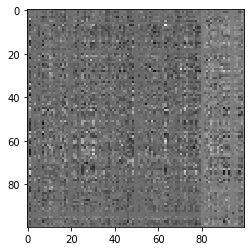

In [79]:
plt.imshow(weights['w_rnn'], cmap='gray')
plt.show()

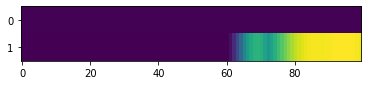

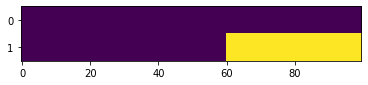

24
[2 1]
20


In [74]:
t = np.random.randint(eyeTrial.batchSize)

plt.figure(figsize = (6.1,1))
plt.imshow(res_y[:,t,:].T, aspect='auto')
plt.show()

plt.figure(figsize = (6.1,1))
plt.imshow(trial_info['desired_output'][:,t,:].T, aspect='auto')
plt.show()

print(trial_info['sample_face'][t])
print(trial_info['conditions'][t,:])
print(trial_info['test_face'][t])

In [91]:
res_y.shape

(100, 512, 2)

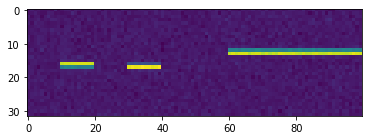

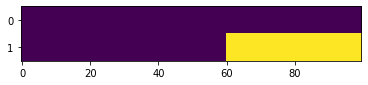

In [31]:
t = np.random.randint(eyeTrial.batchSize)

plt.imshow(trial_info['neural_input'][:,t,:32].T)
plt.show()
plt.figure(figsize = (6.1,1))
plt.imshow(trial_info['desired_output'][:,t,:].T, aspect='auto')
plt.show()

